In [6]:
# run once in a terminal or the first notebook cell (preface with ! on Colab)
!pip install pandas numpy scikit-learn matplotlib seaborn joblib


In [15]:
import pandas as pd

df = pd.read_csv('SchoolDropout.csv')
df.head()


,id,jee_main_score,jee_advanced_score,mock_test_score_avg,board,class_12_percent,attempt_count,coaching_institute,daily_study_hours,family_income,...,peer_pressure_level,mental_health_issues,dropout,board_number,institute_number,income_numbers,PEd_number,loc_number,PPL_Number,MH_Number
0,ST5001,78.95,59.22,59.86,0,70.09,1,2,5.4,0,...,0,0,1.0,0,2,0,0,2,0,0
1,ST5002,70.06,58.75,64.33,2,78.00,1,2,5.5,1,...,0,1,0.0,2,2,1,0,2,0,1
2,ST5003,81.07,37.27,60.83,1,64.36,1,2,7.0,0,...,1,1,1.0,1,2,0,3,1,1,1
3,ST5004,93.32,60.72,69.33,1,73.21,1,2,2.1,0,...,1,1,0.0,1,2,0,1,1,1,1
4,ST5005,68.72,77.73,82.37,0,89.02,1,1,6.3,1,...,2,0,0.0,0,1,1,2,1,2,0


(5001, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5001 non-null   object 
 1   jee_main_score        5001 non-null   float64
 2   jee_advanced_score    5001 non-null   float64
 3   mock_test_score_avg   5001 non-null   float64
 4   board                 5001 non-null   int64  
 5   class_12_percent      5001 non-null   float64
 6   attempt_count         5001 non-null   int64  
 7   coaching_institute    5001 non-null   int64  
 8   daily_study_hours     5001 non-null   float64
 9   family_income         5001 non-null   int64  
 10  parent_education      5001 non-null   int64  
 11  location_type         5001 non-null   int64  
 12  peer_pressure_level   5001 non-null   int64  
 13  mental_health_issues  5001 non-null   int64  
 14  dropout               5000 non-null   float64
 15  board_numb

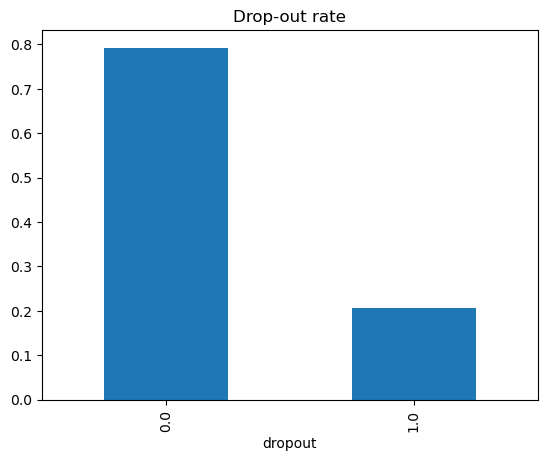

In [16]:
# size & dtypes
print(df.shape)
df.info()

# numeric summary
df.describe().T

# class balance
df['dropout'].value_counts(normalize=True).plot.bar(title='Drop-out rate');


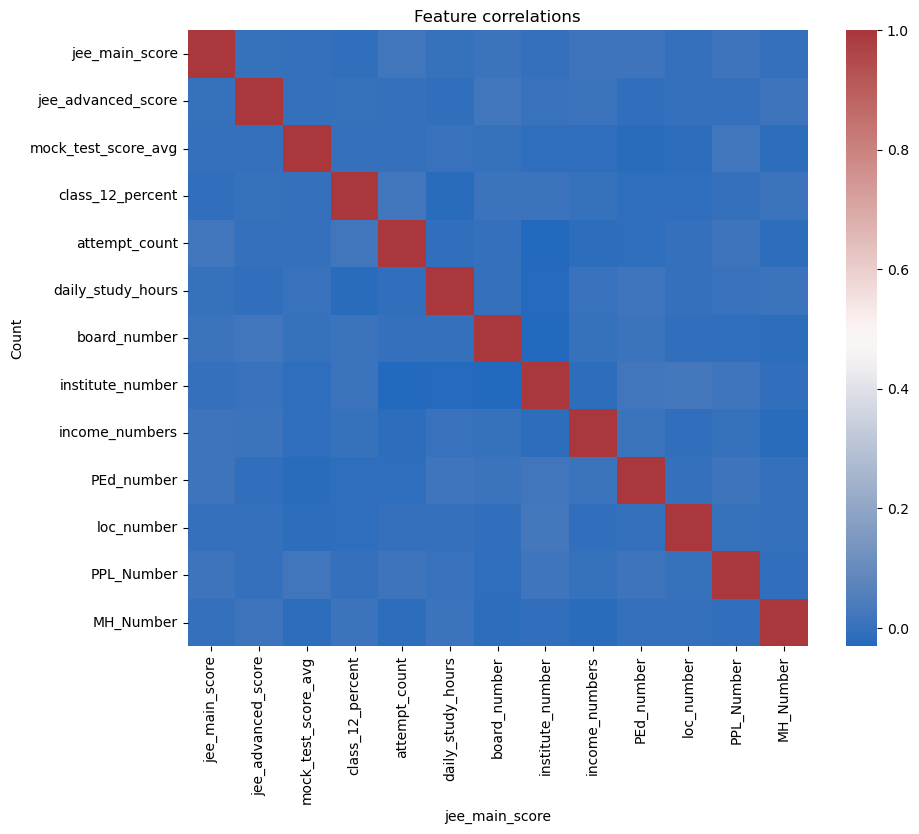

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# correlation heat-map (top 15 features)
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr.iloc[:15, :15], cmap='vlag', annot=False)
plt.title('Feature correlations');

# distribution of a key score
sns.histplot(df['jee_main_score'], kde=True);


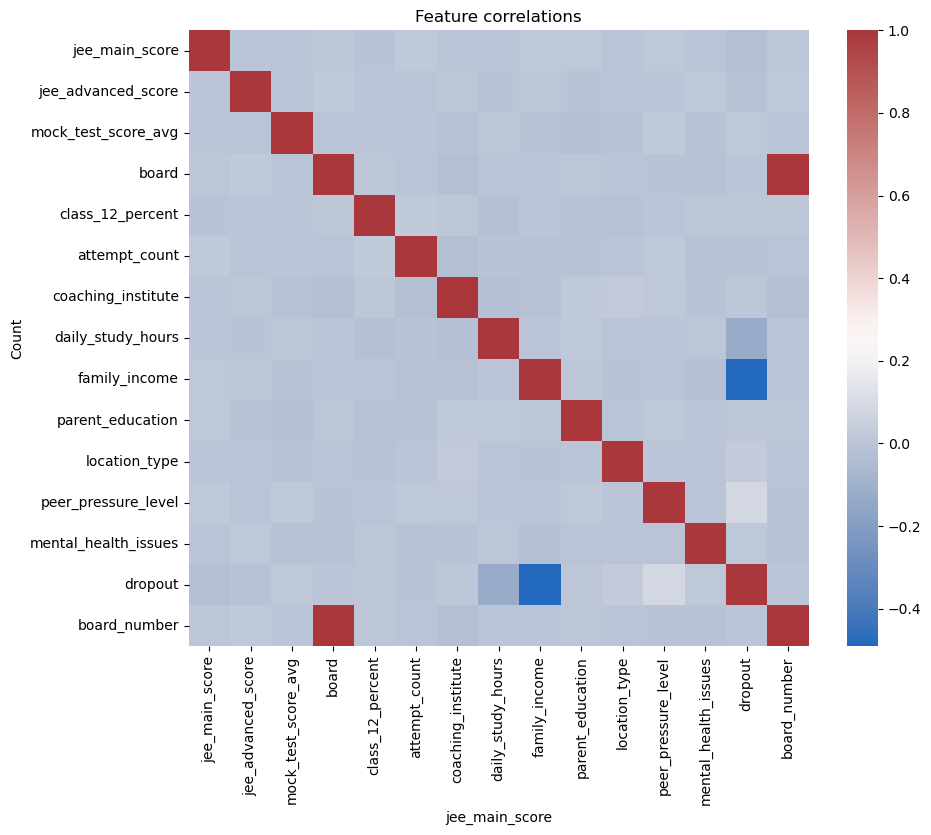

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# correlation heat-map (top 15 features)
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr.iloc[:15, :15], cmap='vlag', annot=False)
plt.title('Feature correlations');

# distribution of a key score
sns.histplot(df['jee_main_score'], kde=True);


In [18]:
# option 1: drop rows with any NA
df = df.dropna()

# option 2: fill numeric NAs with the column median
# from sklearn.impute import SimpleImputer



In [19]:
# everything except the 'id' and label
X = df.drop(columns=['id', 'dropout'])
y = df['dropout']


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

# scale *all* predictors (KNN relies on distance)
numeric_features = X.columns.tolist()
preprocess = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)],
    remainder='drop')

knn = KNeighborsClassifier()

pipe = Pipeline(steps=[('prep', preprocess),
                      ('clf',  knn)])

param_grid = {
    'clf__n_neighbors': list(range(3, 22, 2)),   # 3,5,7,…21
    'clf__weights': ['uniform', 'distance']
}

gs = GridSearchCV(pipe,
                  param_grid,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-1)

gs.fit(X_train, y_train)

print('Best k =', gs.best_params_['clf__n_neighbors'],
      '| weights =', gs.best_params_['clf__weights'],
      '| CV accuracy ≈', round(gs.best_score_, 3))


Best k = 5 | weights = uniform | CV accuracy ≈ 0.809


Test accuracy: 0.803
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       793
         1.0       0.54      0.35      0.43       207

    accuracy                           0.80      1000
   macro avg       0.69      0.64      0.65      1000
weighted avg       0.78      0.80      0.79      1000

Test ROC-AUC: 0.848


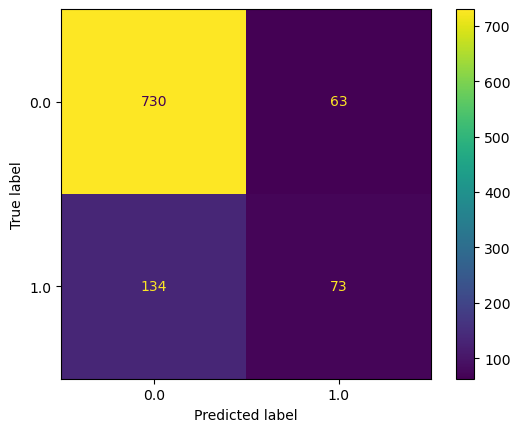

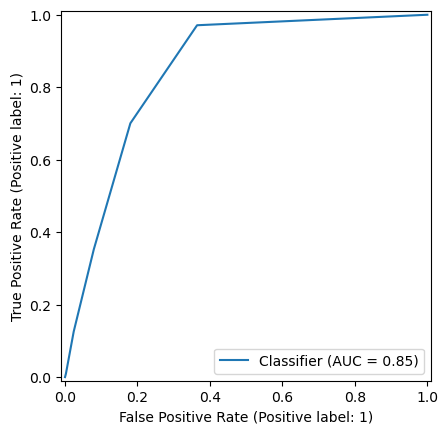

In [22]:
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay)

best_model = gs.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print('Test accuracy:', round(accuracy_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

# ROC-AUC (works even for binary strings 0/1)
print('Test ROC-AUC:', round(roc_auc_score(y_test, y_proba), 3))
RocCurveDisplay.from_predictions(y_test, y_proba);


In [23]:
err = X_test.copy()
err['true'] = y_test.values
err['pred'] = y_pred
err['prob'] = y_proba
err[err['true'] != err['pred']].head(10)


,jee_main_score,jee_advanced_score,mock_test_score_avg,board,class_12_percent,attempt_count,coaching_institute,daily_study_hours,family_income,parent_education,...,board_number,institute_number,income_numbers,PEd_number,loc_number,PPL_Number,MH_Number,true,pred,prob
808,89.58,100.00,60.32,1,76.39,1,1,7.4,0,1,...,1,1,0,1,0,2,1,0.0,1.0,0.6
478,100.00,58.28,90.81,1,79.58,2,2,4.0,0,2,...,1,2,0,2,2,2,0,1.0,0.0,0.2
4925,64.98,57.67,64.59,1,85.78,2,2,4.5,0,3,...,1,2,0,3,0,0,0,1.0,0.0,0.4
4788,42.74,40.96,63.80,1,68.20,2,3,4.3,0,3,...,1,3,0,3,1,2,0,1.0,0.0,0.4
2056,65.33,61.67,51.55,1,84.17,2,3,0.3,1,2,...,1,3,1,2,2,2,1,1.0,0.0,0.2
2125,79.66,35.05,60.71,1,84.16,1,0,4.1,0,2,...,1,0,0,2,1,2,0,1.0,0.0,0.4
4761,81.36,52.28,73.22,0,75.64,2,3,1.8,0,1,...,0,3,0,1,1,0,1,0.0,1.0,0.6
3031,62.78,90.03,61.13,2,72.22,2,0,1.7,0,3,...,2,0,0,3,2,2,1,1.0,0.0,0.2
993,62.45,74.30,62.93,2,79.81,2,2,6.5,0,3,...,2,2,0,3,1,1,0,1.0,0.0,0.4
3413,60.35,70.17,79.93,1,80.63,2,1,7.3,0,0,...,1,1,0,0,1,0,1,0.0,1.0,0.8


In [24]:
import joblib
joblib.dump(best_model, 'knn_dropout_model.joblib')


['knn_dropout_model.joblib']

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# ----- choose the features you want to cluster on -----
cluster_X = df.drop(columns=['id', 'dropout'])      # all predictors (you can subset)

# ----- scale + K-Means in one pipeline -----
k = 3                           # <-- pick a number, or use elbow plot first
kmeans = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=k, random_state=42)
)
df['cluster'] = kmeans.fit_predict(cluster_X)

# ----- quick look -----
print(df['cluster'].value_counts())

# dropout rate per cluster
cluster_summary = (
    df.groupby('cluster')['dropout']
      .agg(['count', 'mean'])      # mean = dropout probability in that cluster
      .rename(columns={'mean': 'dropout_rate'})
)
display(cluster_summary)


cluster
1    1696
0    1674
2    1630
Name: count, dtype: int64


,count,dropout_rate
cluster,,
0,1674,0.255675
1,1696,0.175708
2,1630,0.190184


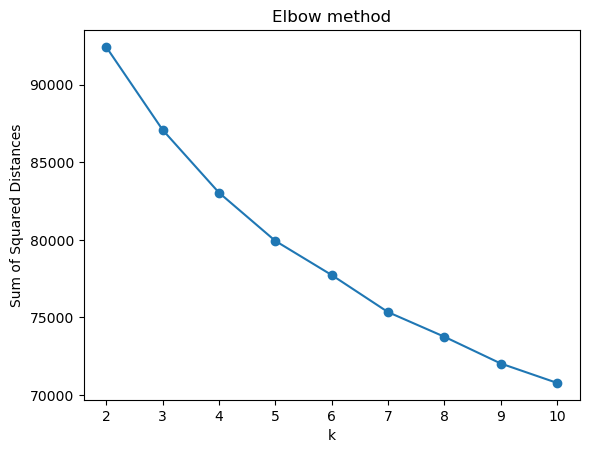

In [26]:
sse = []
K   = range(2, 11)
for k in K:
    km = make_pipeline(StandardScaler(),
                       KMeans(n_clusters=k, random_state=42))
    km.fit(cluster_X)
    sse.append(km[-1].inertia_)      # inertia_ = within-cluster SSE

plt.plot(K, sse, marker='o')
plt.xlabel('k'); plt.ylabel('Sum of Squared Distances'); plt.title('Elbow method');


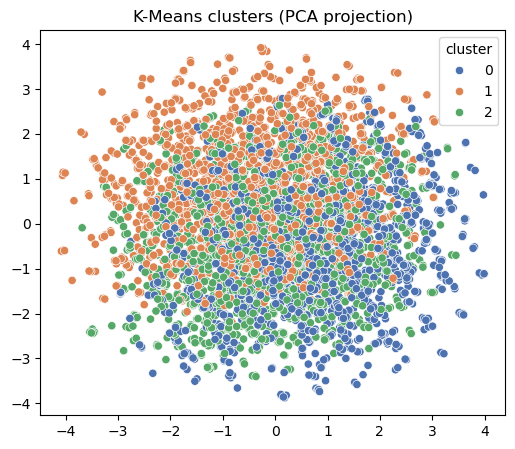

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(cluster_X))
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=df['cluster'], palette='deep')
plt.title('K-Means clusters (PCA projection)');


In [28]:
# add prediction columns
df['dropout_pred']  = best_model.predict(cluster_X)
df['dropout_prob']  = best_model.predict_proba(cluster_X)[:,1]

# view a few at-risk students (probability > 0.5)
at_risk = df[df['dropout_prob'] > 0.5].sort_values('dropout_prob', ascending=False)
at_risk.head()


,id,jee_main_score,jee_advanced_score,mock_test_score_avg,board,class_12_percent,attempt_count,coaching_institute,daily_study_hours,family_income,...,board_number,institute_number,income_numbers,PEd_number,loc_number,PPL_Number,MH_Number,cluster,dropout_pred,dropout_prob
4988,ST9989,74.70,50.30,78.22,1,88.40,2,2,4.2,0,...,1,2,0,1,0,1,0,1,1.0,1.0
3835,ST8836,66.43,65.69,87.62,2,76.15,2,1,6.7,0,...,2,1,0,2,2,1,1,2,1.0,1.0
241,ST5242,70.39,52.52,60.25,0,64.72,1,3,2.6,0,...,0,3,0,2,0,1,1,2,1.0,1.0
1989,ST6990,78.05,65.07,88.55,1,86.32,1,0,5.6,0,...,1,0,0,0,2,1,0,1,1.0,1.0
292,ST5293,63.75,42.06,57.44,2,62.51,1,3,9.0,0,...,2,3,0,0,1,2,1,0,1.0,1.0


In [29]:
df.to_csv('students_with_predictions.csv', index=False)
